In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import wandb
import torch.fft
import seaborn as sns
from tqdm import tqdm
from numpy.polynomial.legendre import legval
from scipy.special import comb
from scipy.special import gamma

In [2]:
from src import Solver
from src import pdeOperator , OperatorConfig
from src import LpLoss, VariationalLoss
from src import BoundaryCondition, BoundaryLoss, BoundaryType, BoundaryLocation
from src import PINN_Net
from src.Training.trainer import Trainer

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

d = pdeOperator()

R = 1.0  # radius
coords = [torch.linspace(-R, R, 10)] 

# Define operator for Poiseuille flow
operator = lambda u, x: d.derivative(u, x, order=2) 

# Source term (not directly used in Poiseuille Flow)
f = lambda x: (-1.6 * (torch.pi**2) * torch.sin(torch.pi * x * 4) - 50 * torch.tanh(5 * x) * (1 - torch.tanh(5 * x)**2))

u_exact = lambda x: 0.1*torch.sin(torch.pi*x*4) + torch.tanh(5*x) 



In [4]:
import numpy as np
lploss = LpLoss(d=1, p=1, reduction='mean')
v_loss = VariationalLoss(dim=1, dx=1/32, reduction="mean" , integration_method="simpson")

def l2_error(pred, true):
    return torch.sqrt(torch.sum((pred - true) ** 2))/torch.sqrt(torch.sum(true**2))

solver = Solver(hidden_size=100, num_layers=1, learning_rate=0.01, device=None, wandb_logs=False, name=None)
TF =True


pde_configurations = OperatorConfig(
            operator=operator,
            weight= torch.tensor(1.0),
            source_function=f,
            u_exact=u_exact,
            trainable=TF,
            weight_function= lambda x: torch.exp(-x),
            pde_loss = l2_error,
            adaptive_nodes = 2,
            update_rate = 50,

        )

bcs = [
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MAX,    
            value= 1 ,
            weight=torch.tensor(1.0),
            trainable=TF,
            weight_function= lambda x: torch.exp(-x),

        ),
        
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MIN,
            value=-1,
            weight=torch.tensor(1.0),
            trainable=TF,
            weight_function = lambda x: torch.exp(-x) ,
        )
    ]

MSE = []
Loss = []

for i in range(1):
    model ,mse , loss , new_coords , risid = solver.solve(dimensions =1, epochs = 1000 , coords = coords, pde_configurations = pde_configurations, boundary_conditions = bcs) 
    MSE.append(mse)
    Loss.append(loss)
    print(mse, loss)


print(f"avergae MSE: {np.mean(MSE)}")
print(f"avergae Loss: {np.mean(Loss)}")
print(f"std MSE: {np.std(MSE)}")
print(f"std Loss: {np.std(Loss)}")

Training:   0%|          | 1/1000 [00:00<02:11,  7.60epoch/s, Loss=4.2399e-01, MSE=2.0120e-01]

Training the model...


Training: 100%|██████████| 1000/1000 [00:11<00:00, 85.81epoch/s, Loss=1.0047e-03, MSE=7.2391e-04]

0.0007239098777063191 0.0010046599199995399
avergae MSE: 0.0007239098777063191
avergae Loss: 0.0010046599199995399
std MSE: 0.0
std Loss: 0.0


## PINN

avergae MSE: 0.04697772059589624
avergae Loss: 0.00042138767921126856
std MSE: 0.023411508672715794
std Loss: 0.0008837540918419517

torch.Size([1, 100])
L2 error: 1.534210205078125


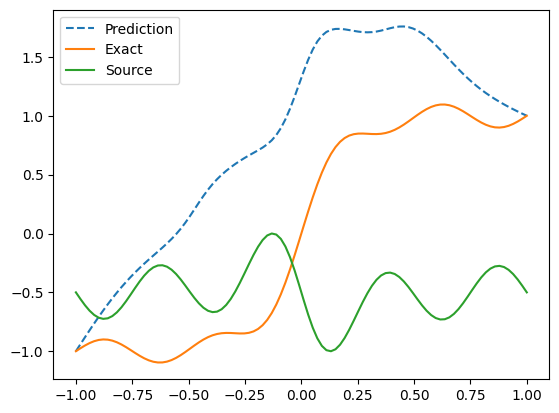

In [15]:
x = torch.linspace(-1, 1 , 100).to(device)
print(x.unsqueeze(0).shape)
f_exact = (f(x) - f(x).max())/(f(x).max() - f(x).min())
u_pred = model(x.unsqueeze(1))
exact = u_exact(x.unsqueeze(-1))


l2 = lploss(u_pred, exact)
print(f"L2 error: {l2}")
plt.plot(x.cpu().detach().numpy().squeeze(), u_pred.cpu().detach().numpy().squeeze(), label="Prediction", linestyle="--")   
plt.plot(x.cpu().detach().numpy().squeeze(), u_exact(x).cpu().detach().numpy().squeeze(), label="Exact")
plt.plot(x.cpu().detach().numpy().squeeze(), f_exact.cpu().detach().numpy().squeeze(), label="Source")
plt.legend()    
plt.show()

In [5]:
pde_configurations = OperatorConfig(
            operator=operator,
            weight= torch.tensor(1.0),
            source_function=f,
            u_exact=u_exact,
            trainable=True,
            weight_function= lambda x: torch.abs(-x),
            pde_loss = F.mse_loss,
            adaptive_nodes = 0,
            update_rate = 100,

        )

bcs = [
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MAX,
            value= torch.tensor(1.0),
            weight=torch.tensor(1.0),
            trainable=True,
            weight_function= lambda x: torch.exp(-x),

        ),
        
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MIN,
            value= torch.tensor(-1.0),
            weight=torch.tensor(1.0),
            trainable=True,
            weight_function = lambda x: torch.exp(-x) ,
        )
    ]



coords = [torch.linspace(-R, R, 12)] 
model , mse , loss , coords , risid = solver.solve(dimensions = 1, coords = coords, pde_configurations = pde_configurations, boundary_conditions = bcs, epochs = 3000 ) 

print(mse , loss)

Training:   0%|          | 4/3000 [00:00<01:16, 39.03epoch/s, Loss=2.4194e+02, MSE=1.5135e-01]

Training the model...


Training: 100%|██████████| 3000/3000 [00:29<00:00, 101.27epoch/s, Loss=2.8266e-02, MSE=1.4703e-01]


0.14702999591827393 0.02826612815260887


In [6]:
pde_configurations = OperatorConfig(
            operator=operator,
            weight= torch.tensor(1.0),
            source_function=f,
            u_exact=u_exact,
            trainable=False,
            weight_function= lambda x: torch.abs(-x),
            pde_loss = F.mse_loss,
            adaptive_nodes = 10,
            update_rate = 100,

        )

bcs = [
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MAX,
            value= torch.tensor(1.0),
            weight=torch.tensor(1.0),
            trainable=False,
            weight_function= lambda x: torch.exp(-x),

        ),
        
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MIN,
            value= torch.tensor(-1.0),
            weight=torch.tensor(1.0),
            trainable=False,
            weight_function = lambda x: torch.exp(-x) ,
        )
    ]


coords = [torch.linspace(-R, R, 12)] 
model , mse , loss , coords , risid = solver.solve(dimensions = 1, coords = coords, pde_configurations = pde_configurations, boundary_conditions = bcs, epochs = 3000 ,plot = False ) 


Training:   0%|          | 1/3000 [00:00<06:00,  8.33epoch/s, Loss=2.4726e+02, MSE=6.1352e-01]

Training the model...


Training: 100%|██████████| 3000/3000 [01:01<00:00, 48.86epoch/s, Loss=1.8556e-02, MSE=1.3541e-02]


In [7]:
pde_configurations = OperatorConfig(
            operator=operator,
            weight= torch.tensor(1.0),
            source_function=f,
            u_exact=u_exact,
            trainable=True,
            weight_function= lambda x: torch.exp(-x),
            pde_loss = F.mse_loss,
            adaptive_nodes = 10,
            update_rate = 200,

        )

bcs = [
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MAX,
            value= torch.tensor(1.0),
            weight=torch.tensor(1.0),
            trainable=True,
            weight_function= lambda x: torch.exp(-x),

        ),
        
        BoundaryCondition(
            type=BoundaryType.DIRICHLET,
            location=BoundaryLocation.X_MIN,
            value= torch.tensor(-1.0),
            weight=torch.tensor(1.0),
            trainable=True,
            weight_function = lambda x: torch.exp(-x)  ,
        )
    ]


coords = [torch.linspace(-R, R, 12)] 
model , mse , loss , coords , risid = solver.solve(dimensions = 1, coords = coords, pde_configurations = pde_configurations, boundary_conditions = bcs, epochs = 500 ,plot = False ) 


Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training the model...


Training:  42%|████▏     | 210/500 [00:05<00:03, 89.35epoch/s, Loss=1.5736e+01, MSE=1.2722e-01] 

torch.Size([22, 1])


Training:  82%|████████▏ | 409/500 [00:07<00:01, 83.84epoch/s, Loss=1.0184e-01, MSE=7.6892e-02] 

torch.Size([32, 1])


Training: 100%|██████████| 500/500 [00:08<00:00, 59.98epoch/s, Loss=1.6226e-02, MSE=2.1757e-02]


0.021756675094366074 0.016226286068558693


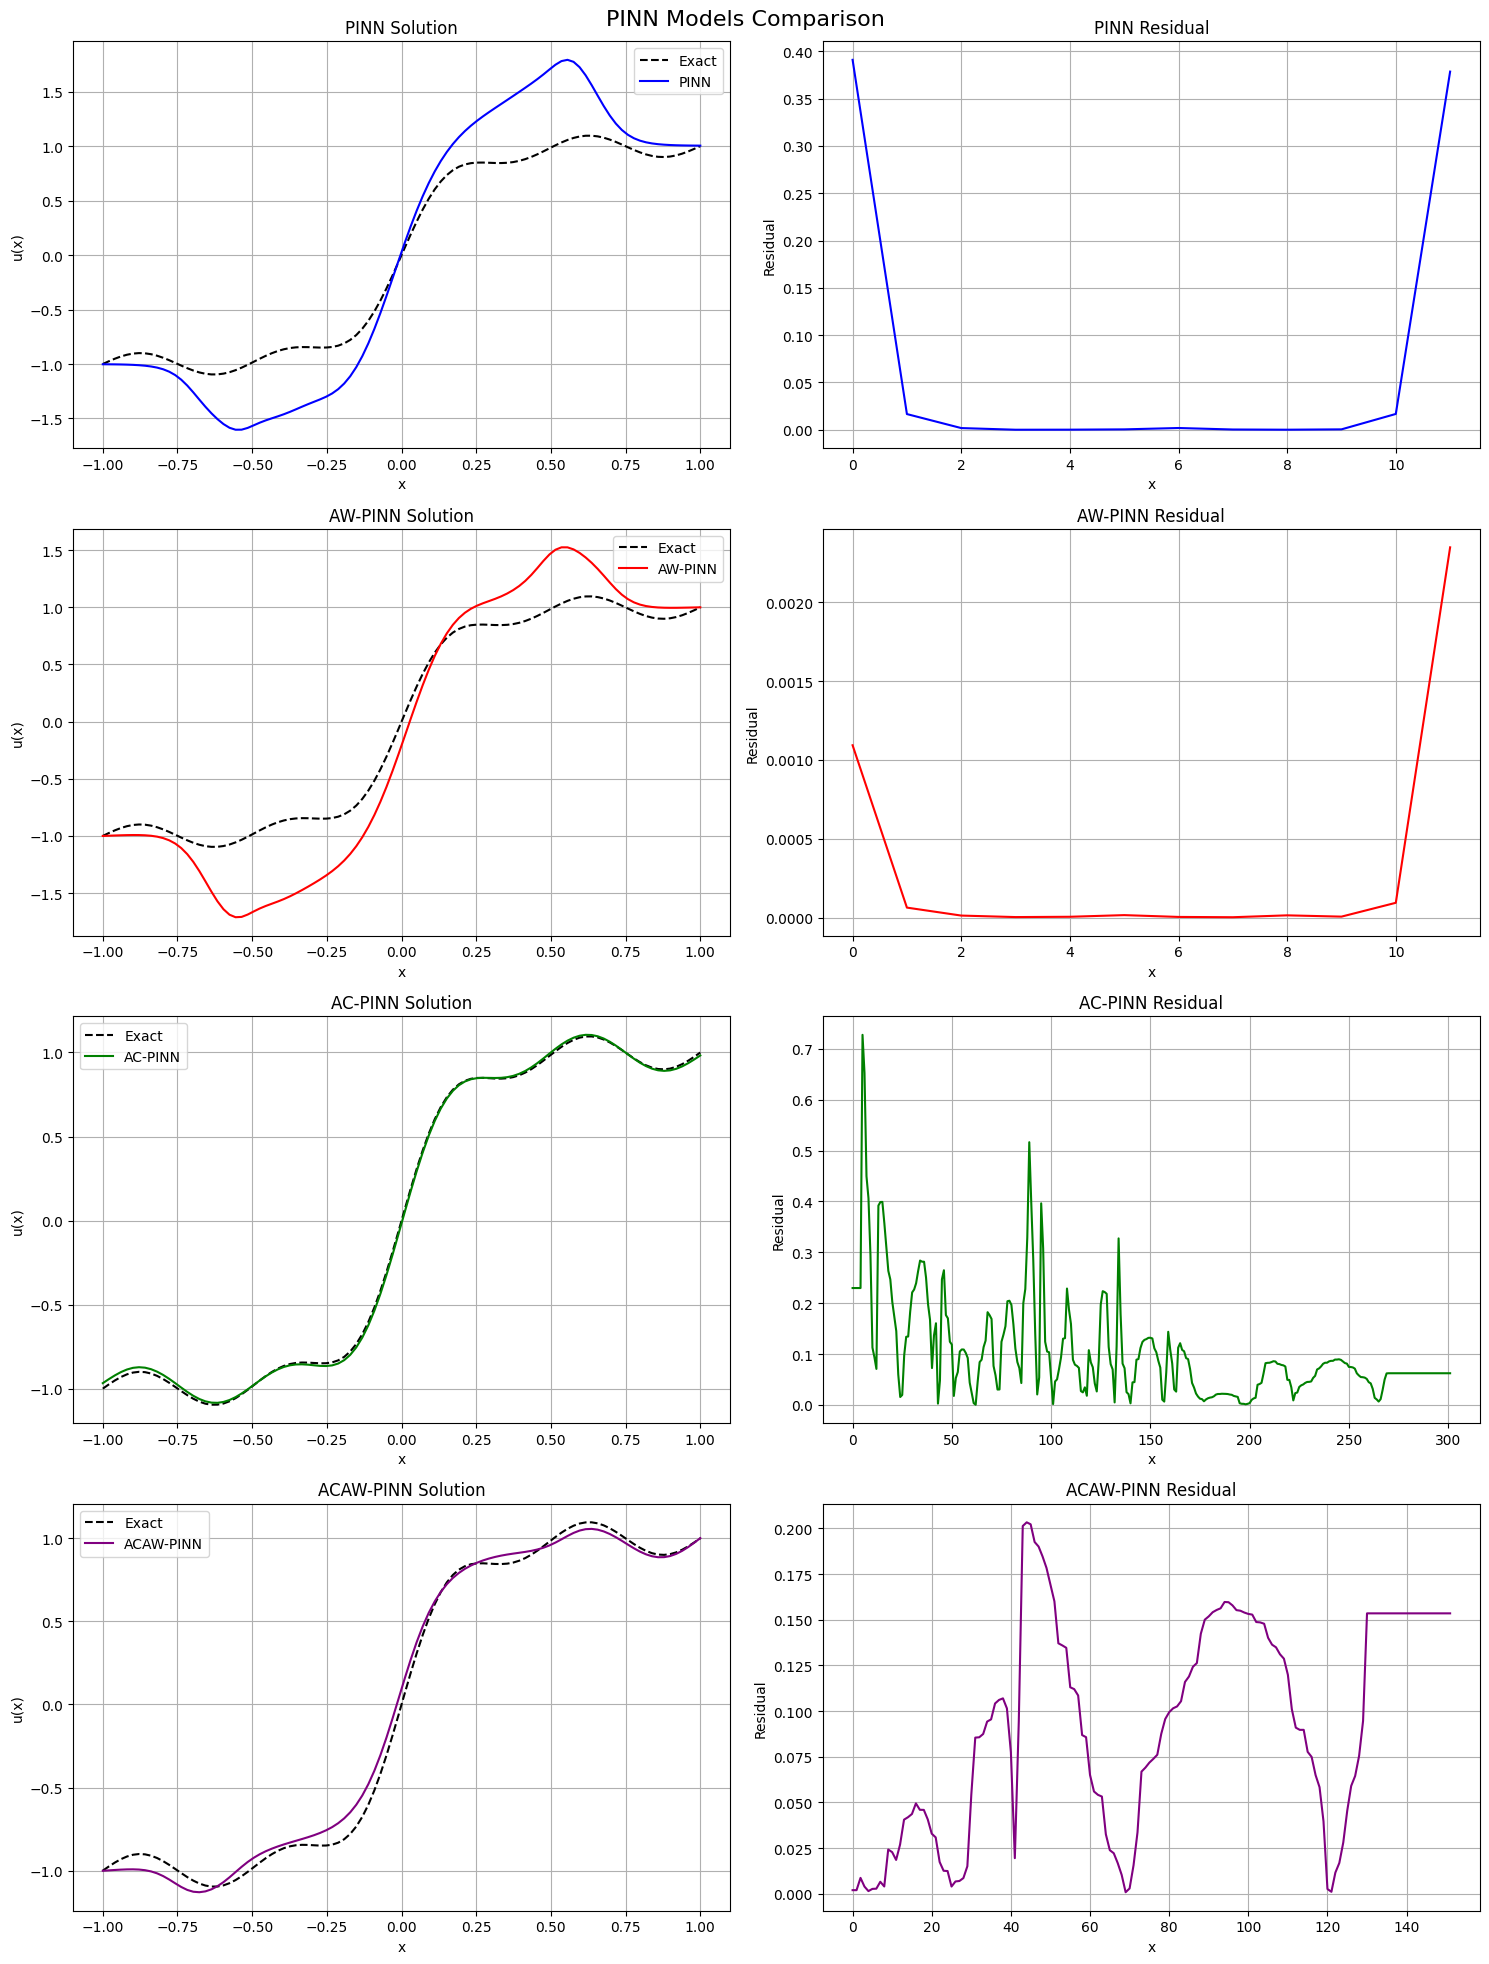

In [115]:
# all models
import matplotlib.pyplot as plt

def plot_1d_comparison(x, u_exact, models, residuals):
    """Plot solutions and residuals for PINN variants"""
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    fig.suptitle('PINN Models Comparison', fontsize=16)
    
    model_names = ['PINN', 'AW-PINN', 'AC-PINN', 'ACAW-PINN']
    colors = ['b', 'r', 'g', 'purple']
    
    for idx, (name, model, resid) in enumerate(zip(model_names, models, residuals)):
        # Solution plot
        axes[idx, 0].plot(x, u_exact.detach().numpy(), 'k--', label='Exact')
        axes[idx, 0].plot(x, model(x.unsqueeze(1)).detach().numpy(), colors[idx], label=name)
        axes[idx, 0].set_title(f'{name} Solution')
        axes[idx, 0].set_xlabel('x')
        axes[idx, 0].set_ylabel('u(x)')
        axes[idx, 0].grid(True)
        axes[idx, 0].legend()
        
        # Residual plot
        axes[idx, 1].plot( resid.detach().numpy(), colors[idx])
        axes[idx, 1].set_title(f'{name} Residual')
        axes[idx, 1].set_xlabel('x')
        axes[idx, 1].set_ylabel('Residual')
        axes[idx, 1].grid(True)
        
    plt.tight_layout()
    plt.show()

# Usage
models = [PINN_model, AW_PINN_model, AC_PINN_model, ACAW_PINN_model]
residuals = [Pinn_risid, AW_Pinn_risid, AC_Pinn_risid, ACAW_Pinn_risid ]
plot_1d_comparison(x, u_exact(x), models, residuals)

## 2 Dimensions

In [42]:
domaine_2d = [-1,1,-1,1]
f_2d = lambda X,Y : torch.exp(-10*(X**2 + Y**2))*(-20)*(1-20*X**2) + torch.exp(-10*(X**2 + Y**2))*(-20)*(1-20*Y**2)
d = pdeOperator()
device = 'cpu'
operator_2d = lambda u,x,y : d.laplacian(u, x, y)
u_exact_2d = lambda x,y :  torch.exp(-10*(x**2 + y**2))
coords_2d = [torch.linspace(-1, 1, 10).to(device), torch.linspace(-1, 1, 10).to(device)]
solver = Solver(
        hidden_size=50,
        num_layers=2,
        learning_rate=0.01,
        device=None,
        wandb_logs=False,
        name=None
)

#lploss = LpLoss(d=2, p=1, size_average=True, reduction=True)
v_loss = VariationalLoss(dim=2, dx=1/16, reduction="sum" , integration_method="simpson")
u = u_exact_2d(*torch.meshgrid(coords_2d))      
boundary_conditions = [
        {'type': 'Dirichlet', 'location': 'y_max', 'value': u[:, -1]},
        {'type': 'Dirichlet', 'location': 'y_min', 'value': u[:, 0]},
        {'type': 'Dirichlet', 'location': 'x_min', 'value': u[0, :]},
        {'type': 'Dirichlet', 'location': 'x_max', 'value': u[-1, :]},
]
weight_function = lambda x: torch.exp(-x)
TF =False

pde_configurations = OperatorConfig(
            operator=operator_2d,
            weight= torch.tensor(1.0),
            source_function=f_2d,
            u_exact=u_exact_2d,
            trainable=TF,
            weight_function= weight_function,
            pde_loss = F.mse_loss,
            adaptive_nodes = 36,
            update_rate = 50,

        )

bcs = [
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Y_MAX,
                value= lambda x,y : torch.exp(-10*(y[0,:]**2 + 1)).squeeze(),
                weight=1,
                trainable=TF,
                weight_function= weight_function,
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Y_MIN,
                value= lambda x,y : torch.exp(-10*(y[0,:]**2 + 1)).squeeze(),
                weight=1,
                trainable=TF,
                weight_function= weight_function,


                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.X_MIN,
                value= lambda x,y : torch.exp(-10*(1 + x[:,0]**2)).squeeze(),
                weight=1,
                trainable=TF,
                weight_function= weight_function,
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.X_MAX,
                value= lambda x,y : torch.exp(-10*(1 + x[:,0]**2)).squeeze(),
                weight=1,
                trainable=TF,
                weight_function= weight_function,
                )
]

adaptive_model , mse , loss , coords  , risid = solver.solve(dimensions = 2 ,
                                coords = coords_2d ,
                                boundary_conditions = bcs ,
                                pde_configurations=pde_configurations,
                                epochs = 500 ,
                                plot = False,
                                )
                                



print(mse , loss)

Training:   1%|          | 4/500 [00:00<00:14, 34.63epoch/s, Loss=9.1815e+00, MSE=2.7000e-02]

Training the model...


Training: 100%|██████████| 500/500 [00:39<00:00, 12.82epoch/s, Loss=4.5809e-04, MSE=4.6832e-06]

4.683178303821478e-06 0.00045808908180333674


In [40]:
lploss = LpLoss(d=2, p=1, reduction='mean')
x = torch.linspace(-1, 1, 500)
y = torch.linspace(-1, 1, 500)
X, Y = torch.meshgrid(x, y)
test_input = torch.cat((X.unsqueeze(-1), Y.unsqueeze(-1)), dim=-1)
u_pred = model(test_input)
u_exact = u_exact_2d(X, Y)
u_pred_adaptive = adaptive_model(test_input)
u_exact_adaptive = u_exact_2d(X, Y)
l2_adaptive = lploss(u_pred_adaptive.squeeze(), u_exact_adaptive.squeeze())
print(f"L2 error: {l2_adaptive}")
print(u_exact.shape, u_pred.shape)
l2 = lploss(u_pred.squeeze(), u_exact.squeeze())
print(f"L2 error: {l2}")

L2 error: 0.018978027626872063
torch.Size([500, 500]) torch.Size([500, 500, 1])
L2 error: 0.04692203924059868


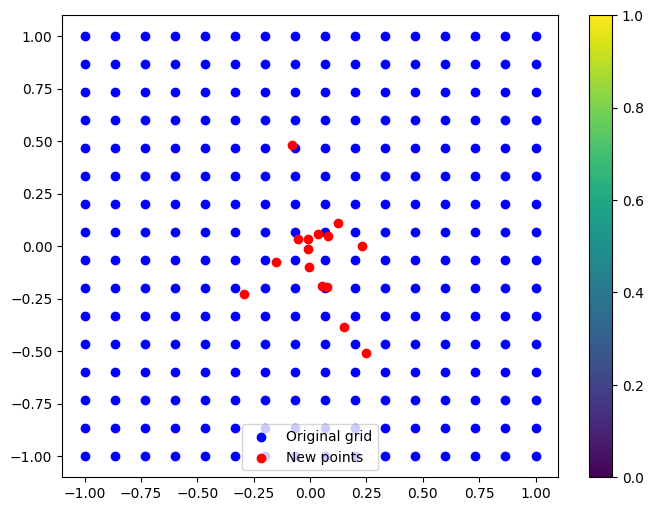

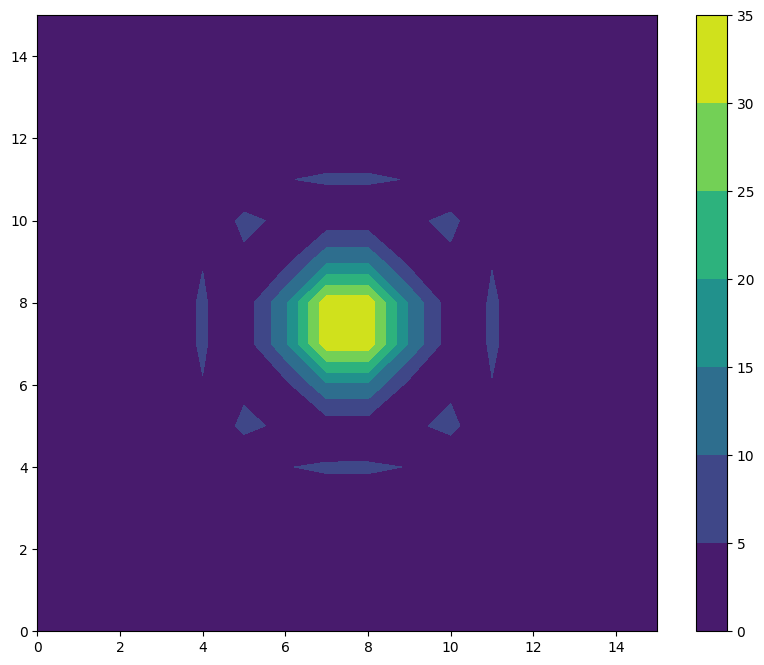

In [74]:
# Assuming risid is a 16x16 tensor of residuals
risid2 = torch.randn(16, 16)

# Create probability distribution from residuals
p = risid / torch.sum(risid)

# Sample indices from the flattened grid proportional to residuals
indices = torch.multinomial(p.flatten(), 15, replacement=True)

# Convert to 2D grid indices
i = indices // 16
j = indices % 16

# Coordinates of sampled grid points
sampled_X = X[i, j]
sampled_Y = Y[i, j]

# Calculate grid spacing
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]

# Generate new points with jitter around sampled locations
torch.manual_seed(42)  # For reproducibility
new_X = sampled_X + (torch.rand(15) - 0.5) * delta_x
new_Y = sampled_Y + (torch.rand(15) - 0.5) * delta_y

# Plot original and new points
plt.figure(figsize=(8, 6))
plt.scatter(X.numpy(), Y.numpy(), color='blue', label='Original grid')
plt.scatter(new_X.numpy(), new_Y.numpy(), color='red', label='New points')
plt.legend()
plt.colorbar()
plt.show()

# Plot risiduals
plt.figure(figsize=(10, 8))
plt.contourf(risid.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

In [51]:
def benchmarking_2D(epochs = 1000 , lr = 0.01 , update_rate = 100 , update_points = 25):
    f_2d = lambda X,Y : torch.exp(-10*(X**2 + Y**2))*(-20)*(1-20*X**2) + torch.exp(-10*(X**2 + Y**2))*(-20)*(1-20*Y**2)
    d = pdeOperator()
    device = 'cpu'
    operator_2d = lambda u,x,y : d.dervation(u, x , order = 2 )* u
    u_exact_2d = lambda x,y :  torch.exp(-10*(x**2 + y**2))
    coords_2d = [torch.linspace(-1, 1, 10).to(device), torch.linspace(-1, 1, 10).to(device)]
    solver = Solver(
            hidden_size=100,
            num_layers=2,
            learning_rate=lr,
            device=None,
            wandb_logs=False,
            name=None
    )
    u = u_exact_2d(*torch.meshgrid(coords_2d))   

    congurations = [[True , update_points] , [True , 0] , [False , update_points] , [False , 0]]
    results = []

    for conf in congurations:
        weight_function = lambda x: torch.exp(-x)
        TF = conf[0]

        pde_configurations = OperatorConfig(
                    operator=operator_2d,
                    weight= torch.tensor(1.0),
                    source_function=f_2d,
                    u_exact=u_exact_2d,
                    trainable=TF,
                    weight_function= weight_function,
                    pde_loss = F.mse_loss,
                    adaptive_nodes = conf[1],
                    update_rate = update_rate,

                )

        bcs = [
                BoundaryCondition(
                        type=BoundaryType.DIRICHLET,
                        location=BoundaryLocation.Y_MAX,
                        value= lambda x,y : torch.exp(-10*(y[0,:]**2 + 1)).squeeze(),
                        weight=1,
                        trainable=TF,
                        weight_function= weight_function,
                        ),
                BoundaryCondition(
                        type=BoundaryType.DIRICHLET,
                        location=BoundaryLocation.Y_MIN,
                        value= lambda x,y : torch.exp(-10*(y[0,:]**2 + 1)).squeeze(),
                        weight=1,
                        trainable=TF,
                        weight_function= weight_function,


                        ),
                BoundaryCondition(
                        type=BoundaryType.DIRICHLET,
                        location=BoundaryLocation.X_MIN,
                        value= lambda x,y : torch.exp(-10*(1 + x[:,0]**2)).squeeze(),
                        weight=1,
                        trainable=TF,
                        weight_function= weight_function,
                        ),
                BoundaryCondition(
                        type=BoundaryType.DIRICHLET,
                        location=BoundaryLocation.X_MAX,
                        value= lambda x,y : torch.exp(-10*(1 + x[:,0]**2)).squeeze(),
                        weight=1,
                        trainable=TF,
                        weight_function= weight_function,
                        )
        ]

        model , mse , loss , coords  , risid = solver.solve(dimensions = 2 ,
                                        coords = coords_2d ,
                                        boundary_conditions = bcs ,
                                        pde_configurations=pde_configurations,
                                        epochs = epochs ,
                                        plot = False,
                                        )
        results.append((model , mse , loss , coords  , risid))

    return results



results = benchmarking_2D(epochs = 5000 , lr = 0.001 , update_rate = 100 , update_points = 25)

        

Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Training the model...


Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Training the model...


Training:   0%|          | 3/5000 [00:00<03:29, 23.90epoch/s, Loss=9.2525e+00, MSE=3.4036e-02]

Training the model...


Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Training the model...


Training: 100%|██████████| 5000/5000 [02:19<00:00, 35.89epoch/s, Loss=1.0343e-05, MSE=4.4387e-05]


lploss: 35.30684280395508
MSE: 1.580969910719432e-05
MSE: 1.5809697288204916e-05


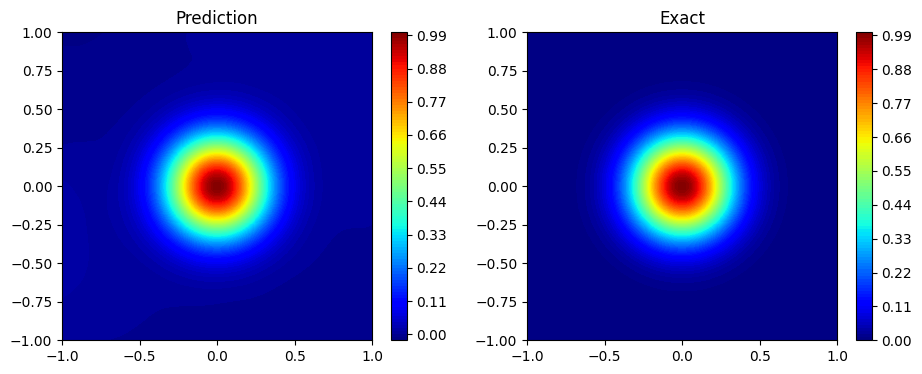

In [31]:
x = torch.linspace(-1, 1, 64).to(device)
y = torch.linspace(-1, 1, 64).to(device)
x, y = torch.meshgrid(x, y)
inputs = torch.cat([x.unsqueeze(-1), y.unsqueeze(-1)], dim=-1)
u_pred = model(inputs)
u_exact = u_exact_2d(x, y)
lploss = LpLoss(d=2, p=1, size_average=True, reduction="mean")

print(f"lploss: {lploss(u_pred, u_exact)}")

print(f"MSE: {F.mse_loss(u_pred.squeeze(), u_exact)}")

u_pred =u_pred.cpu().detach().numpy().squeeze()
u_exact = u_exact.cpu().detach().numpy()

print(f"MSE: {np.mean((u_pred - u_exact)**2)}")

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.contourf(x, y, u_pred, levels=100, cmap="jet")
plt.title("Prediction")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.contourf(x, y, u_exact, levels=100, cmap="jet")
plt.title("Exact")
plt.colorbar()
plt.show()

## 3 Dimensions

In [20]:
domaine_3d = [-1,1,-1,1,-1,1]
d = pdeOperator()
device = "cuda" if torch.cuda.is_available() else "cpu"
f_3d = lambda x,y,z : -3 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)
operator_3d = lambda u,x,y,z : d.laplacian(u , x , y , z)
u_exact_3d = lambda x,y,z : torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)

pde_configurations = OperatorConfig(
        operator=operator_3d,
        source_function=f_3d,
        u_exact=u_exact_3d,
        weight= torch.tensor(1 , dtype=torch.float32),
        trainable=True,
        weight_function= lambda x: torch.exp(-x),
        pde_loss = F.mse_loss,
        adaptive_nodes = 27,
        update_rate = 100,
)


coords_3d = [torch.linspace(-1, 1, 16).to(device), torch.linspace(-1, 1, 16).to(device), torch.linspace(-1, 1, 16).to(device)]
u = u_exact_3d(*torch.meshgrid(coords_3d))

TF =True
bcs = [
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Z_MIN,
                value= lambda x,y,z : u_exact_3d(x , y , z)[0, :, :],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Z_MAX,
                value= lambda x,y,z : u_exact_3d(x , y , z)[-1, :, :],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Y_MIN,
                value= lambda x,y,z : u_exact_3d(x , y , z)[:, 0, :],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.Y_MAX,
                value= lambda x,y,z : u_exact_3d(x , y , z)[:, -1, :],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.X_MIN,
                value= lambda x,y,z : u_exact_3d(x , y , z)[:, :, 0],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                ),
        BoundaryCondition(
                type=BoundaryType.DIRICHLET,
                location=BoundaryLocation.X_MAX,
                value= lambda x,y,z : u_exact_3d(x , y , z)[:, :, -1],
                weight=1,
                trainable=TF,
                weight_function= lambda x: torch.exp(-x),
                )
]


In [19]:
solver = Solver(
        hidden_size=100,
        num_layers=2,
        learning_rate=0.01,
        device=None,
        wandb_logs=False,
        name=None, 
    )
u_pred , mse , loss , coords , risid = solver.solve(dimensions =3 ,
                        coords=coords_3d , 
                        boundary_conditions = bcs,
                        pde_configurations= pde_configurations ,
                        epochs = 500 ,
                        num_test_points = 100)

Training:   1%|          | 3/500 [00:00<00:19, 25.31epoch/s, Loss=2.8163e+01, MSE=1.4237e-01]

Training the model...


Training: 100%|██████████| 500/500 [01:07<00:00,  7.38epoch/s, Loss=1.1619e-02, MSE=4.4316e-03]


RuntimeError: a Tensor with 100 elements cannot be converted to Scalar

In [23]:
def benchmarking(epochs = 1000 , lr = 0.01 , update_rate = 100 , update_points = 25):

        domaine_3d = [-1,1,-1,1,-1,1]
        d = pdeOperator()
        device = "cuda" if torch.cuda.is_available() else "cpu"
        f_3d = lambda x,y,z : -3 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)
        operator_3d = lambda u,x,y,z : d.laplacian(u , x , y , z)
        u_exact_3d = lambda x,y,z : torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)
        solver = Solver(
                hidden_size=100,
                num_layers=2,
                learning_rate=lr,
                device=None,
                wandb_logs=False,
                name=None
        )

        congurations = [[False , 0] , [True , 0]  , [False , update_points],[True , update_points] ]
        results = []

        for conf in congurations:

                pde_configurations = OperatorConfig(
                        operator=operator_3d,
                        source_function=f_3d,
                        u_exact=u_exact_3d,
                        weight= torch.tensor(1 , dtype=torch.float32),
                        trainable=conf[0],
                        weight_function= lambda x: torch.exp(-x),
                        pde_loss = F.mse_loss,
                        adaptive_nodes = conf[1],
                        update_rate = update_rate,
                )

                bcs = [
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.Z_MIN,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[0, :, :],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                ),
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.Z_MAX,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[-1, :, :],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                ),
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.Y_MIN,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[:, 0, :],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                ),
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.Y_MAX,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[:, -1, :],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                ),
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.X_MIN,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[:, :, 0],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                ),
                        BoundaryCondition(
                                type=BoundaryType.DIRICHLET,
                                location=BoundaryLocation.X_MAX,
                                value= lambda x,y,z : u_exact_3d(x , y , z)[:, :, -1],
                                weight=1,
                                trainable=conf[0],
                                weight_function= lambda x: torch.exp(-x),
                                )
                ]

                model , mse , loss , coords  , risid = solver.solve(dimensions = 3 ,
                                                coords = coords_3d ,
                                                boundary_conditions = bcs ,
                                                pde_configurations=pde_configurations,
                                                epochs = epochs ,
                                                plot = False,
                                                )
                
                results.append((model , mse , loss , coords  , risid))

        return results



results = benchmarking(epochs = 500 , lr = 0.001 , update_rate = 50 , update_points = 8)
        

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training the model...


Training:   0%|          | 1/500 [00:00<01:02,  8.03epoch/s, Loss=3.3230e+01, MSE=9.1630e-02]

Training the model...


Training:   0%|          | 1/500 [00:00<00:49,  9.98epoch/s, Loss=3.3260e+01, MSE=9.2948e-02]

Training the model...


Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training the model...


Training: 100%|██████████| 500/500 [06:37<00:00,  1.26epoch/s, Loss=8.7684e-02, MSE=7.5276e-03]


Training:   0%|          | 1/500 [00:00<00:54,  9.22epoch/s, Loss=3.5269e+01, MSE=2.8607e-01]
Training the model...
Training: 100%|██████████| 500/500 [00:51<00:00,  9.63epoch/s, Loss=1.2489e-02, MSE=2.3005e-03]
Training:   0%|          | 1/500 [00:00<00:58,  8.60epoch/s, Loss=3.3281e+01, MSE=5.7015e-01]
Training the model...
Training: 100%|██████████| 500/500 [00:53<00:00,  9.29epoch/s, Loss=1.3597e-02, MSE=4.5890e-03]
Training:   0%|          | 1/500 [00:00<00:49, 10.00epoch/s, Loss=3.3253e+01, MSE=3.5780e-01]
Training the model...
Training: 100%|██████████| 500/500 [02:33<00:00,  3.25epoch/s, Loss=1.2534e-02, MSE=2.2903e-03]
Training:   0%|          | 1/500 [00:00<01:05,  7.66epoch/s, Loss=3.3284e+01, MSE=1.2070e+00]
Training the model...
Training: 100%|██████████| 500/500 [02:27<00:00,  3.39epoch/s, Loss=1.0791e-02, MSE=3.9485e-03]

In [89]:
domaine_2d = [-1,1,-1,1]
f_2d = lambda x,y : torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) + torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2)
operator_2d = lambda u,x,y : d.derivation(u, x, order=2) + d.derivation(u, y, order=2)
u_exact_2d = lambda x,y : x**2 + y**2
solver = Solver()

models , models_names = solver.Benchmark(dimensions =2 ,coords= coords_2d , source_function= f_2d , operator= operator_2d , u_exact = u_exact_2d , epochs = 1 , num_points = 20 , n_test = 500 , lr = 0.01, plot = False , layers= 3 , watch = False ,rate = 500)

Starting benchmark for 2D PDE models.
Training PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50epoch/s, Loss=37.100921630859375, MSE=0.7250586748123169]


Finished training PINN.
----------------------------------------
Training AC-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00,  2.59epoch/s, Loss=37.74620056152344, MSE=0.2564839720726013]


Finished training AC-PINN.
----------------------------------------
Training AW-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00,  1.79epoch/s, Loss=39.08099365234375, MSE=0.20525991916656494]


Finished training AW-PINN.
----------------------------------------
Training ACAW-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00,  2.46epoch/s, Loss=38.28221893310547, MSE=0.686311662197113]

Finished training ACAW-PINN.
----------------------------------------
Benchmark for 2D completed. Trained models: ['PINN', 'AC-PINN', 'AW-PINN', 'ACAW-PINN']


In [92]:
domaine_3d = [-1,1,-1,1,-1,1]
f_3d = lambda x,y,z : -3 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)
operator_3d = lambda u,x,y,z : d.derivation(u, x, order=2) + d.derivation(u, y, order=2) + d.derivation(u, z, order=2)
u_exact_3d = lambda x,y,z : torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)

models, modles_names = solver.Benchmark(dimensions =3 ,coords= coords_3d, source_function= f_3d , operator= operator_3d , u_exact = u_exact_3d , epochs = 1 , num_points = 10 , n_test = 100 , lr = 0.01, plot = False , layers= 3 , watch = False , rate = 1)

Starting benchmark for 3D PDE models.
Training PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00, 19.06epoch/s, Loss=79.8757553100586, MSE=0.5653858184814453]


Finished training PINN.
----------------------------------------
Training AC-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00, 10.60epoch/s, Loss=79.89942169189453, MSE=0.6605468392372131]


Finished training AC-PINN.
----------------------------------------
Training AW-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00, 16.30epoch/s, Loss=79.88895416259766, MSE=0.5240010619163513]


Finished training AW-PINN.
----------------------------------------
Training ACAW-PINN ...


Training: 100%|██████████| 1/1 [00:00<00:00,  4.86epoch/s, Loss=79.87728881835938, MSE=0.18896910548210144]

Finished training ACAW-PINN.
----------------------------------------
Benchmark for 3D completed. Trained models: ['PINN', 'AC-PINN', 'AW-PINN', 'ACAW-PINN']
